# <font color="#548dd4"><center>JellyFish image Classfication</center></font>

## <center>목차</center>
1. 팀원 소개
2. 환경 설정
3. 데이터 전처리
4. 우리가 만든 CNN 모델
5. 우리가 만든 CNN 모델 2차 (Conv2D 1x1 추가)
6. MobileNetV2
7. VGG16
8. VGG19
9. GoogleNet
10. DenseNet
11. 회고

## <center>팀명 : 해파리 감별사 제 3팀</center>
## <center>팀원</center>
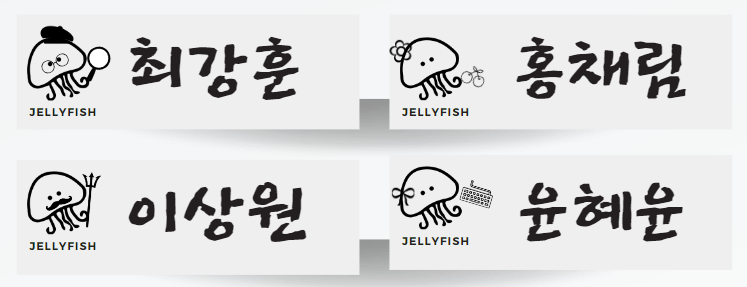

## 기본 환경설정

In [1]:
import numpy as np # numpy 배열을 위해서
import pandas as pd # DataFrame 을 사용하기 위해서
import glob # 파일들의 리스트를 뽑을 때, 파일의 경로를 이용하여 다양하게 사용 가능
import os # glob('*')을 사용해 얻은 리스트의 원소 x를 하나씩 출력하되, 그것이 디렉터리이면 <DIR>이라는 문자열을 뒤에 붙여서 출력
import cv2 # 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
import matplotlib.pyplot as plt # 그래프 및 이미지를 출력하기 위한 라이브러리
import seaborn as sns # matpoltlib의 파생버전, 간단하고 이쁘게 그래프를 그려주는 라이브러리
import tensorflow as tf # tensorflow 를 사용하기위한 라이브러리
import keras # tensorflow에서도 되지만 예비용으로 사용
from tqdm import tqdm # python 진행률 프로세스바
from keras.callbacks import EarlyStopping,ModelCheckpoint # checkpoint 와 earlystopping을 사용하기위한 라이브러리
from sklearn.metrics import confusion_matrix , accuracy_score # cofusion_matrix 와 accuracy_score를 사용하기위한 라이브러리
from sklearn.metrics import classification_report # classification_report 즉, F1-score, presion, recall, accuracy를 한번에 출력
from sklearn.model_selection import train_test_split # train과 valid, test를 나누기 위한 라이브러리
from sklearn.preprocessing import LabelEncoder # 라벨을 부여하기 위한 LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import wandb # 자동으로 모델을 학습하고, 결과 까지 만들어주는 라이브러리
from wandb.keras import WandbCallback # Wandb 라이브러리의 callback 함수를 쓰기위한 라이브러리
from tensorflow.keras.optimizers import Adam # 옵티마이저를 사용하기 위한 라이브러리

In [2]:
wandb.login(key = 'b70c8335b10511e0a72863f129e1113af445e9ae') # Wndb를 사용하기 위해서는 API키가 필요하다.

wandb: Currently logged in as: swl7359 (jellyfishdetectors). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

## 데이터 불러오기 및 전처리

In [3]:
image_train_data = '/aiffel/aiffel/jellyfish/Train_Test_Valid/Train'
train= pd.DataFrame(os.listdir(image_train_data ),columns=['train'])
train.head()

,train
0,teuberculata_jellyfish
1,lions_mane_jellyfish
2,barrel_jellyfish
3,compass_jellyfish
4,Moon_jellyfish


In [4]:
image_test_data = '/aiffel/aiffel/jellyfish/Train_Test_Valid/test'
test = pd.DataFrame(os.listdir(image_test_data ),columns=['test'])
test.head()

,test
0,teuberculata_jellyfish
1,lions_mane_jellyfish
2,barrel_jellyfish
3,compass_jellyfish
4,Moon_jellyfish


In [5]:
files = [i for i in glob.glob(image_train_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,Moon_jellyfish
1,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,lions_mane_jellyfish
2,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,barrel_jellyfish
3,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,Moon_jellyfish
4,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,Moon_jellyfish
...,...,...
2022,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,blue_jellyfish
2023,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,barrel_jellyfish
2024,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,barrel_jellyfish
2025,/aiffel/aiffel/jellyfish/Train_Test_Valid/Trai...,teuberculata_jellyfish


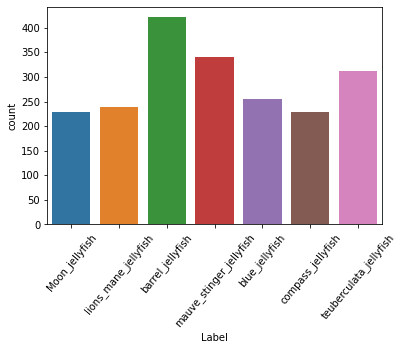

In [6]:
sns.countplot(x = dataframe["Label"])
plt.xticks(rotation = 50);

In [7]:
batch_size = 32

target_size = (224,224)
train= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_data,
    validation_split=0.2,
    subset="training",
    seed=123,  # 동일한 난수 시드 사용
    image_size=target_size,
    batch_size=batch_size,
    
)

valid= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_data,
    validation_split=0.2,
    subset="validation",
    seed=123,  # 동일한 난수 시드 사용
    image_size=target_size,
    batch_size=batch_size,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    image_test_data,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)

Found 2025 files belonging to 7 classes.
Using 1620 files for training.
Found 2025 files belonging to 7 classes.
Using 405 files for validation.
Found 210 files belonging to 7 classes.


In [8]:
class_names = train.class_names
for idx, name in enumerate(class_names):
    print(f"라벨{idx}에 해당하는 클래스 : {name}")

라벨0에 해당하는 클래스 : Moon_jellyfish
라벨1에 해당하는 클래스 : barrel_jellyfish
라벨2에 해당하는 클래스 : blue_jellyfish
라벨3에 해당하는 클래스 : compass_jellyfish
라벨4에 해당하는 클래스 : lions_mane_jellyfish
라벨5에 해당하는 클래스 : mauve_stinger_jellyfish
라벨6에 해당하는 클래스 : teuberculata_jellyfish


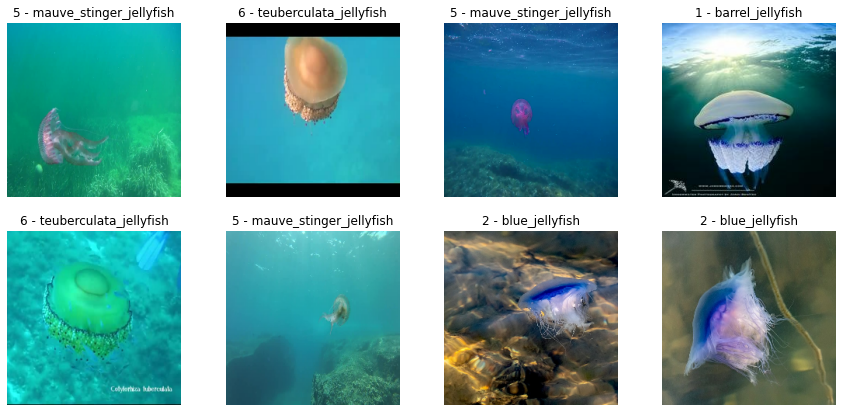

In [9]:
plt.figure(figsize=(15, 30))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{labels[i]} - {class_names[labels[i]]}")
        plt.axis("off")

In [10]:
for images, labels in train:
    print(images.shape)  # 이미지 데이터의 쉐입을 출력합니다.
    print(labels.shape)  # 라벨 데이터의 쉐입을 출력합니다.
    break  # 첫 번째 배치만 확인합니다.

(32, 224, 224, 3)
(32,)


In [11]:
from tensorflow.keras import layers

# Rescaling 레이어 생성
normalization_layer = layers.Rescaling(1./255)

# 훈련, 검증, 테스트 데이터셋에 정규화 레이어 적용
train = train.map(lambda x, y: (normalization_layer(x), y))
valid = valid.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)
datagen1 = ImageDataGenerator()

# Convert MapDataset to NumPy arrays
train_data_numpy = train.unbatch().as_numpy_iterator()
valid_data_numpy = valid.unbatch().as_numpy_iterator()

# Extract images and labels
train_images, train_labels = zip(*train_data_numpy)
valid_images, valid_labels = zip(*valid_data_numpy)

# Convert to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# Apply data augmentation
augmented_train = datagen.flow(train_images, train_labels, batch_size=20)
augmented_val = datagen1.flow(valid_images, valid_labels, batch_size=20)

In [13]:
datagen2 = ImageDataGenerator()

# Convert MapDataset to NumPy arrays
test_data_numpy = test.unbatch().as_numpy_iterator()

# Extract images and labels
test_images, test_labels = zip(*test_data_numpy)

# Convert to NumPy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)


# Apply data augmentation
test_generator = datagen2.flow(test_images, test_labels, batch_size = 20)

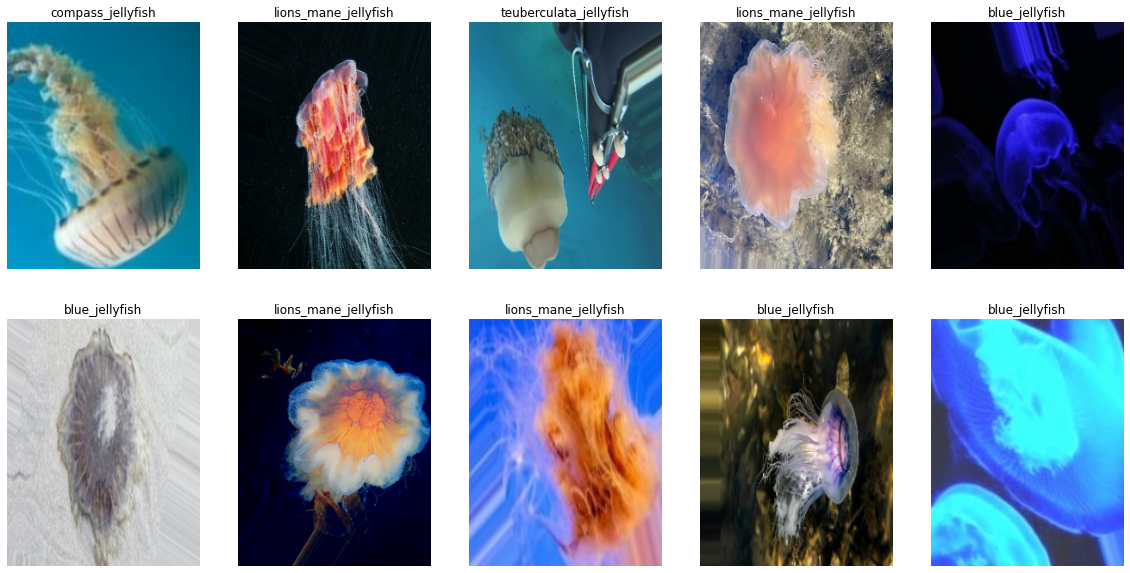

In [14]:
# 시각화를 위한 코드
plt.figure(figsize=(20, 10))

# augmented_train에서 데이터를 가져와 시각화
num_batches = 2  # 시각화할 배치의 수
images_per_batch = 5  # 각 배치에서 시각화할 이미지 수

for i in range(num_batches):
    augmented_images, augmented_labels = augmented_train.next()  # 다음 증강된 데이터 배치를 가져옴
    for j in range(images_per_batch):
        plt.subplot(num_batches, images_per_batch, i * images_per_batch + j + 1)
        plt.imshow((augmented_images[j] * 255).astype('uint8'), cmap='gray', aspect='auto')
        plt.title(class_names[augmented_labels[j]])
        plt.axis('off')

plt.show()

## 우리가 만든 CNN 1차 모델

In [15]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate": {
            "values": [0.0007294]  
        },
        "epoch": {
            "values": [139]
        }
    }
}

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    restore_best_weights=True,
    monitor='val_loss',
    min_delta=0.01,
    patience=15,
    verbose=1,
    mode='auto'
)


def train():
    default_config = {
        "input" : (224,224,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.0007294,
        "optimizer": "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 139
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model

    model = Sequential()
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(config.filter, config.kernel, padding='same', input_shape=config.input))
    model.add(Activation(config.activation))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation(config.activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation(config.activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # FLATTERN => DENSE => RELU => DROPOUT
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation(config.activation))
    model.add(Dense(32))
    model.add(Activation(config.activation))
    model.add(Dense(7, activation='softmax'))

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
    # Optimizer 설정
    if config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(augmented_train,
              epochs = config.epoch,
              validation_data = augmented_val,
              callbacks = [
                  WandbCallback(validation_data = augmented_val,
                                        lables = class_names,
                                        predictions = 10,
                                        input_type = "images"),
              early_stopping
              ])
    
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [17]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'jellyfishdetectors',
                       project = 'jellyfish7')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=1)

Create sweep with ID: puz5vt09
Sweep URL: https://wandb.ai/jellyfishdetectors/jellyfish7/sweeps/puz5vt09


wandb: Agent Starting Run: 7bvqqwhz with config:
wandb: 	epoch: 139
wandb: 	learning_rate: 0.0007294
wandb: Currently logged in as: choikanghoon30 (jellyfishdetectors). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/139
81/81 [==============================] - 79s 199ms/step - loss: 2.0921 - accuracy: 0.2722 - val_loss: 1.6652 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 5.5s


Epoch 2/139
81/81 [==============================] - 17s 203ms/step - loss: 1.5022 - accuracy: 0.4222 - val_loss: 1.4725 - val_accuracy: 0.4617
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.8s


Epoch 3/139
81/81 [==============================] - 18s 217ms/step - loss: 1.4406 - accuracy: 0.4383 - val_loss: 1.4715 - val_accuracy: 0.4395
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 4.7s


Epoch 4/139
81/81 [==============================] - 17s 205ms/step - loss: 1.4114 - accuracy: 0.4543 - val_loss: 1.3759 - val_accuracy: 0.4667
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.8s


Epoch 5/139
81/81 [==============================] - 16s 203ms/step - loss: 1.3163 - accuracy: 0.4963 - val_loss: 1.2895 - val_accuracy: 0.5407
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 4.6s


Epoch 6/139
81/81 [==============================] - 16s 195ms/step - loss: 1.2728 - accuracy: 0.5179 - val_loss: 1.2668 - val_accuracy: 0.5259
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 5.2s


Epoch 7/139
81/81 [==============================] - 16s 197ms/step - loss: 1.2523 - accuracy: 0.5401 - val_loss: 1.2477 - val_accuracy: 0.4864
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 4.2s


Epoch 8/139
81/81 [==============================] - 16s 197ms/step - loss: 1.2095 - accuracy: 0.5586 - val_loss: 1.2464 - val_accuracy: 0.5531
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.5s


Epoch 9/139
81/81 [==============================] - 16s 198ms/step - loss: 1.1933 - accuracy: 0.5512 - val_loss: 1.2144 - val_accuracy: 0.5704
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 4.3s


Epoch 10/139
81/81 [==============================] - 16s 198ms/step - loss: 1.1599 - accuracy: 0.5698 - val_loss: 1.1337 - val_accuracy: 0.5432
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.9s


Epoch 11/139
81/81 [==============================] - 16s 200ms/step - loss: 1.1133 - accuracy: 0.5827 - val_loss: 1.0916 - val_accuracy: 0.5654
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.8s


Epoch 12/139
81/81 [==============================] - 18s 219ms/step - loss: 1.1097 - accuracy: 0.5852 - val_loss: 1.2190 - val_accuracy: 0.5778
Epoch 13/139
81/81 [==============================] - 17s 213ms/step - loss: 1.0649 - accuracy: 0.6160 - val_loss: 1.1065 - val_accuracy: 0.6025
Epoch 14/139
81/81 [==============================] - 18s 215ms/step - loss: 1.0258 - accuracy: 0.6167 - val_loss: 1.0647 - val_accuracy: 0.6148
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.7s


Epoch 15/139
81/81 [==============================] - 18s 218ms/step - loss: 0.9974 - accuracy: 0.6265 - val_loss: 1.0971 - val_accuracy: 0.58029912 - accura - ETA: 0s - loss: 0.9985 - accuracy: 
Epoch 16/139
81/81 [==============================] - 18s 218ms/step - loss: 0.9955 - accuracy: 0.6302 - val_loss: 1.0502 - val_accuracy: 0.6148
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.7s


Epoch 17/139
81/81 [==============================] - 18s 219ms/step - loss: 0.9582 - accuracy: 0.6444 - val_loss: 1.1855 - val_accuracy: 0.5506
Epoch 18/139
81/81 [==============================] - 17s 203ms/step - loss: 0.9786 - accuracy: 0.6364 - val_loss: 0.9636 - val_accuracy: 0.6741
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.7s


Epoch 19/139
81/81 [==============================] - 17s 207ms/step - loss: 0.9276 - accuracy: 0.6617 - val_loss: 0.9422 - val_accuracy: 0.6691
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.8s


Epoch 20/139
81/81 [==============================] - 19s 236ms/step - loss: 0.8897 - accuracy: 0.6833 - val_loss: 0.9557 - val_accuracy: 0.6469
Epoch 21/139
81/81 [==============================] - 16s 199ms/step - loss: 0.8911 - accuracy: 0.6586 - val_loss: 0.8712 - val_accuracy: 0.6815
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.7s


Epoch 22/139
81/81 [==============================] - 16s 198ms/step - loss: 0.8623 - accuracy: 0.6827 - val_loss: 0.9849 - val_accuracy: 0.6494
Epoch 23/139
81/81 [==============================] - 16s 197ms/step - loss: 0.8076 - accuracy: 0.7123 - val_loss: 0.9145 - val_accuracy: 0.6741
Epoch 24/139
81/81 [==============================] - 16s 199ms/step - loss: 0.8156 - accuracy: 0.7074 - val_loss: 0.8896 - val_accuracy: 0.6988
Epoch 25/139
81/81 [==============================] - 17s 208ms/step - loss: 0.7952 - accuracy: 0.7142 - val_loss: 0.9044 - val_accuracy: 0.6840
Epoch 26/139
81/81 [==============================] - 17s 213ms/step - loss: 0.7490 - accuracy: 0.7327 - val_loss: 0.8338 - val_accuracy: 0.6938
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 4.1s


Epoch 27/139
81/81 [==============================] - 19s 228ms/step - loss: 0.7386 - accuracy: 0.7327 - val_loss: 0.8400 - val_accuracy: 0.7160
Epoch 28/139
81/81 [==============================] - 18s 220ms/step - loss: 0.7094 - accuracy: 0.7414 - val_loss: 0.7553 - val_accuracy: 0.7605
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.7s


Epoch 29/139
81/81 [==============================] - 18s 218ms/step - loss: 0.6984 - accuracy: 0.7543 - val_loss: 0.7604 - val_accuracy: 0.7210
Epoch 30/139
81/81 [==============================] - 17s 214ms/step - loss: 0.6943 - accuracy: 0.7401 - val_loss: 0.7846 - val_accuracy: 0.7309
Epoch 31/139
81/81 [==============================] - 18s 217ms/step - loss: 0.6683 - accuracy: 0.7630 - val_loss: 0.6882 - val_accuracy: 0.7630
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.9s


Epoch 32/139
81/81 [==============================] - 18s 225ms/step - loss: 0.6493 - accuracy: 0.7654 - val_loss: 0.6956 - val_accuracy: 0.7679
Epoch 33/139
81/81 [==============================] - 18s 221ms/step - loss: 0.6657 - accuracy: 0.7605 - val_loss: 0.8068 - val_accuracy: 0.7037
Epoch 34/139
81/81 [==============================] - 18s 218ms/step - loss: 0.6052 - accuracy: 0.7889 - val_loss: 0.6964 - val_accuracy: 0.7704
Epoch 35/139
81/81 [==============================] - 18s 215ms/step - loss: 0.6452 - accuracy: 0.7772 - val_loss: 0.7722 - val_accuracy: 0.7407
Epoch 36/139
81/81 [==============================] - 18s 219ms/step - loss: 0.5869 - accuracy: 0.7883 - val_loss: 0.6818 - val_accuracy: 0.7852
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.7s


Epoch 37/139
81/81 [==============================] - 18s 221ms/step - loss: 0.5552 - accuracy: 0.7889 - val_loss: 0.6959 - val_accuracy: 0.7728
Epoch 38/139
81/81 [==============================] - 18s 219ms/step - loss: 0.6295 - accuracy: 0.7790 - val_loss: 0.7254 - val_accuracy: 0.7333
Epoch 39/139
81/81 [==============================] - 18s 218ms/step - loss: 0.5440 - accuracy: 0.7938 - val_loss: 0.6251 - val_accuracy: 0.7877
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.8s


Epoch 40/139
81/81 [==============================] - 18s 223ms/step - loss: 0.5607 - accuracy: 0.7963 - val_loss: 0.8073 - val_accuracy: 0.7383
Epoch 41/139
81/81 [==============================] - 18s 219ms/step - loss: 0.5351 - accuracy: 0.8105 - val_loss: 0.6539 - val_accuracy: 0.7852
Epoch 42/139
81/81 [==============================] - 18s 219ms/step - loss: 0.4718 - accuracy: 0.8309 - val_loss: 0.5415 - val_accuracy: 0.8000
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.7s


Epoch 43/139
81/81 [==============================] - 18s 217ms/step - loss: 0.4569 - accuracy: 0.8395 - val_loss: 0.6092 - val_accuracy: 0.8025
Epoch 44/139
81/81 [==============================] - 18s 215ms/step - loss: 0.4934 - accuracy: 0.8370 - val_loss: 0.5741 - val_accuracy: 0.8074
Epoch 45/139
81/81 [==============================] - 18s 215ms/step - loss: 0.5146 - accuracy: 0.8099 - val_loss: 0.7018 - val_accuracy: 0.7432
Epoch 46/139
81/81 [==============================] - 18s 217ms/step - loss: 0.4820 - accuracy: 0.8290 - val_loss: 0.6020 - val_accuracy: 0.8074
Epoch 47/139
81/81 [==============================] - 18s 220ms/step - loss: 0.4386 - accuracy: 0.8451 - val_loss: 0.6493 - val_accuracy: 0.8000
Epoch 48/139
81/81 [==============================] - 18s 221ms/step - loss: 0.4418 - accuracy: 0.8370 - val_loss: 0.6910 - val_accuracy: 0.7679
Epoch 49/139
81/81 [==============================] - 17s 215ms/step - loss: 0.4676 - accuracy: 0.8309 - val_loss: 0.5368 - val_ac

wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_201302-7bvqqwhz/files/model-best)... Done. 3.8s


Epoch 50/139
81/81 [==============================] - 18s 222ms/step - loss: 0.4057 - accuracy: 0.8568 - val_loss: 0.6685 - val_accuracy: 0.7901
Epoch 51/139
81/81 [==============================] - 18s 222ms/step - loss: 0.4484 - accuracy: 0.8414 - val_loss: 0.6656 - val_accuracy: 0.7827
Epoch 52/139
81/81 [==============================] - 18s 219ms/step - loss: 0.4937 - accuracy: 0.8222 - val_loss: 0.7168 - val_accuracy: 0.7556
Epoch 53/139
81/81 [==============================] - 18s 218ms/step - loss: 0.4020 - accuracy: 0.8586 - val_loss: 0.5834 - val_accuracy: 0.8148
Epoch 54/139
81/81 [==============================] - 18s 219ms/step - loss: 0.3962 - accuracy: 0.8580 - val_loss: 0.7560 - val_accuracy: 0.7481
Epoch 55/139
81/81 [==============================] - 18s 220ms/step - loss: 0.3580 - accuracy: 0.8710 - val_loss: 0.5993 - val_accuracy: 0.8049
Epoch 56/139
81/81 [==============================] - 18s 216ms/step - loss: 0.3754 - accuracy: 0.8667 - val_loss: 0.5937 - val_ac

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁
val_accuracy,▁▂▁▃▃▃▄▃▄▄▄▄▅▅▆▅▅▆▆▇▆▇▇▇▇▇▆▇▇██▇█▇█▇▇▇██
val_loss,█▇▇▆▆▅▅▄▅▅▄▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▂▂▁▂
Test Accuracy Rate:,69.05
Test Error Rate:,30.95
accuracy,0.89074
best_epoch,48


## 우리가 만든 2차 CNN 모델 ( Conv2D 1x1 추가 )

- 연산량을 줄일 수 있을 것 같기에 googleNet에서 사용한 Conv2D 1x1 layer를 추가

In [62]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate": {
            "values": [0.001]  
        },
        "epoch": {
            "values": [80]
        }
    }
}

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    restore_best_weights=True,
    monitor='val_loss',
    min_delta=0.01,
    patience=15,
    verbose=1,
    mode='auto'
)


def train():
    default_config = {
        "input" : (224,224,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.001,
        "optimizer": "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 73
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model

    model = Sequential()
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(config.filter, config.kernel, padding='same', input_shape=config.input))
    model.add(Activation(config.activation))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation(config.activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (1, 1), padding='valid'))  # 추가된 1x1 CONV2D 레이어
    model.add(Activation(config.activation)) # 활성화 함수 층 추가
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation(config.activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # FLATTERN => DENSE => RELU => DROPOUT
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation(config.activation))
    model.add(Dense(32))
    model.add(Activation(config.activation))
    model.add(Dense(7, activation='softmax'))

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
    # Optimizer 설정
    if config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(augmented_train,
              epochs = config.epoch,
              validation_data = augmented_val,
              callbacks = [
                  WandbCallback(validation_data = augmented_val,
                                        lables = class_names,
                                        predictions = 10,
                                        input_type = "images"),
              early_stopping
              ])
    
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [64]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'jellyfishdetectors',
                       project = 'jellyfish8')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=1)

Create sweep with ID: 5gz6ysj9
Sweep URL: https://wandb.ai/jellyfishdetectors/jellyfish8/sweeps/5gz6ysj9


wandb: Agent Starting Run: cgu6zowe with config:
wandb: 	epoch: 80
wandb: 	learning_rate: 0.001


Epoch 1/80
81/81 [==============================] - 16s 196ms/step - loss: 1.7780 - accuracy: 0.2778 - val_loss: 1.5435 - val_accuracy: 0.4099
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 4.9s


Epoch 2/80
81/81 [==============================] - 16s 202ms/step - loss: 1.5266 - accuracy: 0.4142 - val_loss: 1.3640 - val_accuracy: 0.47411
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.5s


Epoch 3/80
81/81 [==============================] - 16s 200ms/step - loss: 1.3975 - accuracy: 0.4599 - val_loss: 1.3433 - val_accuracy: 0.4889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.6s


Epoch 4/80
81/81 [==============================] - 16s 199ms/step - loss: 1.3475 - accuracy: 0.4914 - val_loss: 1.2849 - val_accuracy: 0.5086
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 4.8s


Epoch 5/80
81/81 [==============================] - 16s 198ms/step - loss: 1.2724 - accuracy: 0.5241 - val_loss: 1.1865 - val_accuracy: 0.5457
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.6s


Epoch 6/80
81/81 [==============================] - 16s 196ms/step - loss: 1.2330 - accuracy: 0.5284 - val_loss: 1.1818 - val_accuracy: 0.5580
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 4.2s


Epoch 7/80
81/81 [==============================] - 16s 199ms/step - loss: 1.1965 - accuracy: 0.5296 - val_loss: 1.1487 - val_accuracy: 0.5877
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.8s


Epoch 8/80
81/81 [==============================] - 16s 198ms/step - loss: 1.1424 - accuracy: 0.5802 - val_loss: 1.1220 - val_accuracy: 0.5827
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 4.3s


Epoch 9/80
81/81 [==============================] - 16s 195ms/step - loss: 1.1483 - accuracy: 0.5648 - val_loss: 1.1229 - val_accuracy: 0.5531
Epoch 10/80
81/81 [==============================] - 16s 194ms/step - loss: 1.0853 - accuracy: 0.5926 - val_loss: 1.0769 - val_accuracy: 0.5852
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 6.0s


Epoch 11/80
81/81 [==============================] - 16s 194ms/step - loss: 1.1254 - accuracy: 0.5821 - val_loss: 1.0994 - val_accuracy: 0.6173
Epoch 12/80
81/81 [==============================] - 16s 193ms/step - loss: 1.0228 - accuracy: 0.6160 - val_loss: 1.1023 - val_accuracy: 0.5827
Epoch 13/80
81/81 [==============================] - 16s 196ms/step - loss: 1.0297 - accuracy: 0.6105 - val_loss: 1.0820 - val_accuracy: 0.6025
Epoch 14/80
81/81 [==============================] - 16s 196ms/step - loss: 0.9878 - accuracy: 0.6451 - val_loss: 1.0157 - val_accuracy: 0.6469
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 4.1s


Epoch 15/80
81/81 [==============================] - 16s 201ms/step - loss: 0.9780 - accuracy: 0.6383 - val_loss: 1.1216 - val_accuracy: 0.5753
Epoch 16/80
81/81 [==============================] - 16s 197ms/step - loss: 0.9317 - accuracy: 0.6580 - val_loss: 0.9262 - val_accuracy: 0.6765
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.6s


Epoch 17/80
81/81 [==============================] - 16s 195ms/step - loss: 0.9566 - accuracy: 0.6414 - val_loss: 1.0668 - val_accuracy: 0.6099
Epoch 18/80
81/81 [==============================] - 16s 192ms/step - loss: 0.9201 - accuracy: 0.6599 - val_loss: 0.9541 - val_accuracy: 0.6840
Epoch 19/80
81/81 [==============================] - 16s 195ms/step - loss: 0.8729 - accuracy: 0.6759 - val_loss: 0.8935 - val_accuracy: 0.6914
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.8s


Epoch 20/80
81/81 [==============================] - 16s 196ms/step - loss: 0.8696 - accuracy: 0.6840 - val_loss: 0.9082 - val_accuracy: 0.6543
Epoch 21/80
81/81 [==============================] - 16s 196ms/step - loss: 0.8663 - accuracy: 0.6858 - val_loss: 1.0308 - val_accuracy: 0.6469
Epoch 22/80
81/81 [==============================] - 16s 195ms/step - loss: 0.8061 - accuracy: 0.6994 - val_loss: 0.9594 - val_accuracy: 0.6444
Epoch 23/80
81/81 [==============================] - 16s 195ms/step - loss: 0.7889 - accuracy: 0.7216 - val_loss: 0.8913 - val_accuracy: 0.6790
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.5s


Epoch 24/80
81/81 [==============================] - 16s 200ms/step - loss: 0.7698 - accuracy: 0.7136 - val_loss: 0.9766 - val_accuracy: 0.6765
Epoch 25/80
81/81 [==============================] - 16s 197ms/step - loss: 0.7174 - accuracy: 0.7420 - val_loss: 0.8633 - val_accuracy: 0.6790
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 4.8s


Epoch 26/80
81/81 [==============================] - 16s 200ms/step - loss: 0.7360 - accuracy: 0.7284 - val_loss: 0.8606 - val_accuracy: 0.6963
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.7s


Epoch 27/80
81/81 [==============================] - 17s 205ms/step - loss: 0.6681 - accuracy: 0.7506 - val_loss: 0.9321 - val_accuracy: 0.6914
Epoch 28/80
81/81 [==============================] - 16s 195ms/step - loss: 0.7016 - accuracy: 0.7451 - val_loss: 0.9573 - val_accuracy: 0.6593
Epoch 29/80
81/81 [==============================] - 16s 198ms/step - loss: 0.6685 - accuracy: 0.7574 - val_loss: 0.9439 - val_accuracy: 0.7012
Epoch 30/80
81/81 [==============================] - 16s 197ms/step - loss: 0.6650 - accuracy: 0.7580 - val_loss: 0.9845 - val_accuracy: 0.6864
Epoch 31/80
81/81 [==============================] - 16s 194ms/step - loss: 0.6250 - accuracy: 0.7747 - val_loss: 0.7969 - val_accuracy: 0.7457
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 7.0s


Epoch 32/80
81/81 [==============================] - 16s 199ms/step - loss: 0.6135 - accuracy: 0.7679 - val_loss: 0.8382 - val_accuracy: 0.7383
Epoch 33/80
81/81 [==============================] - 16s 196ms/step - loss: 0.6458 - accuracy: 0.7772 - val_loss: 0.7976 - val_accuracy: 0.7136
Epoch 34/80
81/81 [==============================] - 16s 196ms/step - loss: 0.6188 - accuracy: 0.7728 - val_loss: 1.0690 - val_accuracy: 0.6494
Epoch 35/80
81/81 [==============================] - 16s 197ms/step - loss: 0.6490 - accuracy: 0.7642 - val_loss: 0.7842 - val_accuracy: 0.7284
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 3.6s


Epoch 36/80
81/81 [==============================] - 16s 199ms/step - loss: 0.5941 - accuracy: 0.7895 - val_loss: 0.7364 - val_accuracy: 0.7407
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best/assets


wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240112_001617-cgu6zowe/files/model-best)... Done. 6.7s


Epoch 37/80
81/81 [==============================] - 16s 200ms/step - loss: 0.5590 - accuracy: 0.8006 - val_loss: 0.8494 - val_accuracy: 0.7185
Epoch 38/80
81/81 [==============================] - 16s 194ms/step - loss: 0.5467 - accuracy: 0.8142 - val_loss: 0.8312 - val_accuracy: 0.7309
Epoch 39/80
81/81 [==============================] - 16s 201ms/step - loss: 0.5496 - accuracy: 0.8037 - val_loss: 0.9537 - val_accuracy: 0.7160
Epoch 40/80
81/81 [==============================] - 16s 196ms/step - loss: 0.6141 - accuracy: 0.7840 - val_loss: 0.8781 - val_accuracy: 0.6963
Epoch 41/80
81/81 [==============================] - 16s 194ms/step - loss: 0.5523 - accuracy: 0.8043 - val_loss: 0.8698 - val_accuracy: 0.7407
Epoch 42/80
81/81 [==============================] - 16s 194ms/step - loss: 0.5132 - accuracy: 0.8167 - val_loss: 0.8664 - val_accuracy: 0.7432
Epoch 43/80
81/81 [==============================] - 16s 196ms/step - loss: 0.4589 - accuracy: 0.8327 - val_loss: 0.8679 - val_accuracy:

Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▃▃▄▄▄▅▄▅▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇██▇█▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁
val_accuracy,▁▂▂▃▄▄▄▄▅▄▄▄▆▅▆▅▅▅▆▆▆▆▆▆▇▆▅▇▇▇▆▆▇▇▇▇▇▇▇█
val_loss,█▆▆▆▅▅▄▄▄▄▄▄▃▄▃▂▄▃▃▂▂▃▃▃▂▂▄▁▁▂▃▂▂▂▃▂▂▁▁▂
Test Accuracy Rate:,66.67
Test Error Rate:,33.33
accuracy,0.85556
best_epoch,35


## MobileNetV2

In [21]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate": {
            "values": [0.0001]  
        },
        "epoch": {
            "values": [20]
        }
    }
}

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

early_stopping = EarlyStopping(
    restore_best_weights=True,
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto')
    
def train():
    default_config = {
        "input" : (224,224,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.0001,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 20
    }

    wandb.init(config = default_config)
    config = wandb.config
    


    base_model = tf.keras.applications.MobileNetV2(input_shape=config.input,
                                                   include_top=False,
                                                   weights='imagenet')


    
    
        
    
    # 글로벌 어버리지를 통해서 크기만 줄이고 그대로 남기겠다.
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    # 레이어 구성후 마지막 소프트맥스의 units 값을 7로 만들어준다.
    dense_layer = tf.keras.layers.Dense(
        units=512,
        activation=config.activation
    )
    
    prediction_layer = tf.keras.layers.Dense(
        units=7,
        activation='softmax'
    )
    

    model = tf.keras.Sequential([
        base_model,             # 베이스 모델
        global_average_layer,   # 글로벌 평균 풀링 레이어
        dense_layer,            # 밀집 레이어 (ReLU 활성화)
        prediction_layer        # 예측 레이어 (Softmax 활성화)
    ])
    

    base_model.trainable = False

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
 # Optimizer 설정
    if config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # WandbCallback 함수는 후술합니다.
    
    model.fit(train_images, train_labels,
              epochs = config.epoch,
              validation_data = (valid_images, valid_labels),
              callbacks = [WandbCallback(validation_data = (valid_images, valid_labels),
                                        lables = class_names,
                                        predictions = 10,
                                        input_type = "images"),early_stopping])
    
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [23]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'jellyfishdetectors',
                       project = 'jellyfish7')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=1)

Create sweep with ID: 9g9ywf9n
Sweep URL: https://wandb.ai/jellyfishdetectors/jellyfish7/sweeps/9g9ywf9n


wandb: Agent Starting Run: z8e7l35r with config:
wandb: 	epoch: 20
wandb: 	learning_rate: 0.0001


9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/20
51/51 [==============================] - 9s 91ms/step - loss: 1.2539 - accuracy: 0.5753 - val_loss: 0.7944 - val_accuracy: 0.7654


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 2/20
51/51 [==============================] - 3s 50ms/step - loss: 0.5589 - accuracy: 0.8519 - val_loss: 0.5652 - val_accuracy: 0.8395


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 3/20
51/51 [==============================] - 3s 50ms/step - loss: 0.3801 - accuracy: 0.9049 - val_loss: 0.4317 - val_accuracy: 0.8716


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 4/20
51/51 [==============================] - 3s 50ms/step - loss: 0.2814 - accuracy: 0.9389 - val_loss: 0.3792 - val_accuracy: 0.8938


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 5/20
51/51 [==============================] - 3s 51ms/step - loss: 0.2194 - accuracy: 0.9568 - val_loss: 0.3097 - val_accuracy: 0.9086


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 6/20
51/51 [==============================] - 3s 51ms/step - loss: 0.1708 - accuracy: 0.9710 - val_loss: 0.2808 - val_accuracy: 0.9309


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 7/20
51/51 [==============================] - 3s 50ms/step - loss: 0.1408 - accuracy: 0.9815 - val_loss: 0.2583 - val_accuracy: 0.9210


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 8/20
51/51 [==============================] - 3s 50ms/step - loss: 0.1155 - accuracy: 0.9852 - val_loss: 0.2404 - val_accuracy: 0.9309


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 9/20
51/51 [==============================] - 3s 51ms/step - loss: 0.0970 - accuracy: 0.9889 - val_loss: 0.2263 - val_accuracy: 0.9407


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 10/20
51/51 [==============================] - 3s 51ms/step - loss: 0.0803 - accuracy: 0.9920 - val_loss: 0.2130 - val_accuracy: 0.9383


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 11/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0685 - accuracy: 0.9951 - val_loss: 0.2046 - val_accuracy: 0.9432


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 12/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0574 - accuracy: 0.9969 - val_loss: 0.1937 - val_accuracy: 0.9506


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 13/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0502 - accuracy: 0.9988 - val_loss: 0.1827 - val_accuracy: 0.9457


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 14/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0431 - accuracy: 0.9994 - val_loss: 0.1833 - val_accuracy: 0.9432
Epoch 15/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0378 - accuracy: 0.9994 - val_loss: 0.1714 - val_accuracy: 0.9531


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 16/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0331 - accuracy: 0.9994 - val_loss: 0.1729 - val_accuracy: 0.9580
Epoch 17/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0292 - accuracy: 0.9994 - val_loss: 0.1648 - val_accuracy: 0.9605


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 18/20
51/51 [==============================] - 3s 51ms/step - loss: 0.0262 - accuracy: 1.0000 - val_loss: 0.1620 - val_accuracy: 0.9605


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 19/20
51/51 [==============================] - 3s 50ms/step - loss: 0.0234 - accuracy: 1.0000 - val_loss: 0.1589 - val_accuracy: 0.9630


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210105-z8e7l35r/files/model-best)... Done. 0.1s


Epoch 20/20
7/7 [==============================] - 1s 97ms/step - loss: 0.3975 - accuracy: 0.8619


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▆▆▇▇███████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇█▇▇██████
val_loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Test Accuracy Rate:,86.19
Test Error Rate:,13.81
accuracy,1.0
best_epoch,18


## VGG 16

In [24]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate": {
            "values": [0.001]  
        },
        "epoch": {
            "values": [30]
        }
    }
}

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

early_stopping = EarlyStopping(
    restore_best_weights=True,
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto')
    
def train():
    default_config = {
        "input" : (224,224,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.001,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 30
    }

    wandb.init(config = default_config)
    config = wandb.config
    


    base_model = tf.keras.applications.VGG16(input_shape=config.input,
                                                   include_top=False,
                                                   weights='imagenet')


    
    
        
    
    # 글로벌 어버리지를 통해서 크기만 줄이고 그대로 남기겠다.
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    # 레이어 구성후 마지막 소프트맥스의 units 값을 7로 만들어준다.
    dense_layer = tf.keras.layers.Dense(
        units=512,
        activation=config.activation
    )
    
    prediction_layer = tf.keras.layers.Dense(
        units=7,
        activation='softmax'
    )
    

    model = tf.keras.Sequential([
        base_model,             # 베이스 모델
        global_average_layer,   # 글로벌 평균 풀링 레이어
        dense_layer,            # 밀집 레이어 (ReLU 활성화)
        prediction_layer        # 예측 레이어 (Softmax 활성화)
    ])
    

    base_model.trainable = False

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
 # Optimizer 설정
    if config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # WandbCallback 함수는 후술합니다.
    
    model.fit(train_images, train_labels,
              epochs = config.epoch,
              validation_data = (valid_images, valid_labels),
              callbacks = [WandbCallback(validation_data = (valid_images, valid_labels),
                                        lables = class_names,
                                        predictions = 10,
                                        input_type = "images"),early_stopping])
    
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [26]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'jellyfishdetectors',
                       project = 'jellyfish7')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=1)

Create sweep with ID: e5b40bdz
Sweep URL: https://wandb.ai/jellyfishdetectors/jellyfish7/sweeps/e5b40bdz


wandb: Agent Starting Run: qb729yyp with config:
wandb: 	epoch: 30
wandb: 	learning_rate: 0.001


58900480/58889256 [==============================] - 0s 0us/step
Epoch 1/30
51/51 [==============================] - 27s 391ms/step - loss: 1.5646 - accuracy: 0.4340 - val_loss: 1.1938 - val_accuracy: 0.6469
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 2/30
51/51 [==============================] - 9s 167ms/step - loss: 1.0281 - accuracy: 0.7062 - val_loss: 0.9066 - val_accuracy: 0.7235
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.4s


Epoch 3/30
51/51 [==============================] - 8s 162ms/step - loss: 0.7988 - accuracy: 0.7654 - val_loss: 0.7700 - val_accuracy: 0.7531
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 4/30
51/51 [==============================] - 8s 164ms/step - loss: 0.6513 - accuracy: 0.8148 - val_loss: 0.6833 - val_accuracy: 0.7605
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 5/30
51/51 [==============================] - 9s 171ms/step - loss: 0.5651 - accuracy: 0.8309 - val_loss: 0.6038 - val_accuracy: 0.8123
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 6/30
51/51 [==============================] - 9s 177ms/step - loss: 0.5006 - accuracy: 0.8543 - val_loss: 0.5553 - val_accuracy: 0.8123
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 7/30
51/51 [==============================] - 9s 175ms/step - loss: 0.4407 - accuracy: 0.8685 - val_loss: 0.5092 - val_accuracy: 0.8296
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.4s


Epoch 8/30
51/51 [==============================] - 9s 170ms/step - loss: 0.4095 - accuracy: 0.8833 - val_loss: 0.4856 - val_accuracy: 0.8469
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 9/30
51/51 [==============================] - 8s 166ms/step - loss: 0.3818 - accuracy: 0.8907 - val_loss: 0.4972 - val_accuracy: 0.8222
Epoch 10/30
51/51 [==============================] - 9s 169ms/step - loss: 0.3487 - accuracy: 0.8988 - val_loss: 0.4865 - val_accuracy: 0.8494
Epoch 11/30
51/51 [==============================] - 9s 171ms/step - loss: 0.3328 - accuracy: 0.9031 - val_loss: 0.4511 - val_accuracy: 0.8420
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.4s


Epoch 12/30
51/51 [==============================] - 9s 169ms/step - loss: 0.3008 - accuracy: 0.9167 - val_loss: 0.4621 - val_accuracy: 0.8444
Epoch 13/30
51/51 [==============================] - 9s 171ms/step - loss: 0.2822 - accuracy: 0.9191 - val_loss: 0.3988 - val_accuracy: 0.8741
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.6s


Epoch 14/30
51/51 [==============================] - 9s 169ms/step - loss: 0.2597 - accuracy: 0.9284 - val_loss: 0.4125 - val_accuracy: 0.8593
Epoch 15/30
51/51 [==============================] - 9s 171ms/step - loss: 0.2444 - accuracy: 0.9333 - val_loss: 0.4875 - val_accuracy: 0.8321
Epoch 16/30
51/51 [==============================] - 9s 170ms/step - loss: 0.2403 - accuracy: 0.9358 - val_loss: 0.3794 - val_accuracy: 0.8765
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 17/30
51/51 [==============================] - 9s 168ms/step - loss: 0.2084 - accuracy: 0.9444 - val_loss: 0.3630 - val_accuracy: 0.8864
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 18/30
51/51 [==============================] - 9s 168ms/step - loss: 0.2072 - accuracy: 0.9432 - val_loss: 0.3679 - val_accuracy: 0.8790
Epoch 19/30
51/51 [==============================] - 9s 172ms/step - loss: 0.1829 - accuracy: 0.9586 - val_loss: 0.3940 - val_accuracy: 0.8691
Epoch 20/30
51/51 [==============================] - 9s 174ms/step - loss: 0.1712 - accuracy: 0.9574 - val_loss: 0.3395 - val_accuracy: 0.8889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.4s


Epoch 21/30
51/51 [==============================] - 9s 170ms/step - loss: 0.1615 - accuracy: 0.9617 - val_loss: 0.3431 - val_accuracy: 0.8790
Epoch 22/30
51/51 [==============================] - 9s 169ms/step - loss: 0.1687 - accuracy: 0.9580 - val_loss: 0.3451 - val_accuracy: 0.8840
Epoch 23/30
51/51 [==============================] - 9s 169ms/step - loss: 0.1581 - accuracy: 0.9556 - val_loss: 0.3311 - val_accuracy: 0.8938
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_210942-qb729yyp/files/model-best)... Done. 0.5s


Epoch 24/30
51/51 [==============================] - 9s 168ms/step - loss: 0.1376 - accuracy: 0.9679 - val_loss: 0.3556 - val_accuracy: 0.8815
Epoch 25/30
51/51 [==============================] - 9s 169ms/step - loss: 0.1304 - accuracy: 0.9741 - val_loss: 0.3379 - val_accuracy: 0.8963
Epoch 26/30
51/51 [==============================] - 9s 171ms/step - loss: 0.1199 - accuracy: 0.9728 - val_loss: 0.3928 - val_accuracy: 0.8741
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
7/7 [==============================] - 5s 814ms/step - loss: 0.6123 - accuracy: 0.8333


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▆▆▆▇▆▇▆▇▇▇▆▇██▇██████▇
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂
Test Accuracy Rate:,83.33
Test Error Rate:,16.67
accuracy,0.97284
best_epoch,22


## VGG19

In [27]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate": {
            "values": [0.001]  
        },
        "epoch": {
            "values": [40]
        }
    }
}

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

early_stopping = EarlyStopping(
    restore_best_weights=True,
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto')
    
def train():
    default_config = {
        "input" : (224,224,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.001,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 40
    }

    wandb.init(config = default_config)
    config = wandb.config
    


    base_model = tf.keras.applications.VGG19(input_shape=config.input,
                                                   include_top=False,
                                                   weights='imagenet')


    
    
        
    
    # 글로벌 어버리지를 통해서 크기만 줄이고 그대로 남기겠다.
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    # 레이어 구성후 마지막 소프트맥스의 units 값을 7로 만들어준다.
    dense_layer = tf.keras.layers.Dense(
        units=512,
        activation=config.activation
    )
    
    prediction_layer = tf.keras.layers.Dense(
        units=7,
        activation='softmax'
    )
    

    model = tf.keras.Sequential([
        base_model,             # 베이스 모델
        global_average_layer,   # 글로벌 평균 풀링 레이어
        dense_layer,            # 밀집 레이어 (ReLU 활성화)
        prediction_layer        # 예측 레이어 (Softmax 활성화)
    ])
    

    base_model.trainable = False

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
 # Optimizer 설정
    if config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    # WandbCallback 함수는 후술합니다.
    
    model.fit(train_images, train_labels,
              epochs = config.epoch,
              validation_data = (valid_images, valid_labels),
              callbacks = [WandbCallback(validation_data = (valid_images, valid_labels),
                                        lables = class_names,
                                        predictions = 10,
                                        input_type = "images"),early_stopping])
    
    test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [29]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'jellyfishdetectors',
                       project = 'jellyfish7')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=1)

Create sweep with ID: shbza97y
Sweep URL: https://wandb.ai/jellyfishdetectors/jellyfish7/sweeps/shbza97y


wandb: Agent Starting Run: q7nhp8dr with config:
wandb: 	epoch: 40
wandb: 	learning_rate: 0.001


80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/40
51/51 [==============================] - 12s 221ms/step - loss: 1.6217 - accuracy: 0.4105 - val_loss: 1.3052 - val_accuracy: 0.5432
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.7s


Epoch 2/40
51/51 [==============================] - 11s 214ms/step - loss: 1.1628 - accuracy: 0.6062 - val_loss: 0.9852 - val_accuracy: 0.6889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 3/40
51/51 [==============================] - 11s 207ms/step - loss: 0.9411 - accuracy: 0.6889 - val_loss: 0.8434 - val_accuracy: 0.7383
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.9s


Epoch 4/40
51/51 [==============================] - 10s 204ms/step - loss: 0.7985 - accuracy: 0.7401 - val_loss: 0.8193 - val_accuracy: 0.7284
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 5/40
51/51 [==============================] - 10s 204ms/step - loss: 0.7026 - accuracy: 0.7778 - val_loss: 0.6910 - val_accuracy: 0.7827
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 6/40
51/51 [==============================] - 10s 205ms/step - loss: 0.6304 - accuracy: 0.7975 - val_loss: 0.6657 - val_accuracy: 0.7778
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 7/40
51/51 [==============================] - 11s 208ms/step - loss: 0.5670 - accuracy: 0.8216 - val_loss: 0.5661 - val_accuracy: 0.8148
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 8/40
51/51 [==============================] - 10s 206ms/step - loss: 0.5133 - accuracy: 0.8463 - val_loss: 0.5730 - val_accuracy: 0.7975
Epoch 9/40
51/51 [==============================] - 10s 206ms/step - loss: 0.4829 - accuracy: 0.8506 - val_loss: 0.5075 - val_accuracy: 0.8272
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.9s


Epoch 10/40
51/51 [==============================] - 10s 204ms/step - loss: 0.4523 - accuracy: 0.8599 - val_loss: 0.4721 - val_accuracy: 0.8395
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 11/40
51/51 [==============================] - 10s 204ms/step - loss: 0.4230 - accuracy: 0.8784 - val_loss: 0.4877 - val_accuracy: 0.8346
Epoch 12/40
51/51 [==============================] - 11s 208ms/step - loss: 0.3810 - accuracy: 0.8870 - val_loss: 0.4232 - val_accuracy: 0.8568
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 13/40
51/51 [==============================] - 10s 206ms/step - loss: 0.3609 - accuracy: 0.8951 - val_loss: 0.4359 - val_accuracy: 0.8617
Epoch 14/40
51/51 [==============================] - 10s 206ms/step - loss: 0.3469 - accuracy: 0.9019 - val_loss: 0.3906 - val_accuracy: 0.8765
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 15/40
51/51 [==============================] - 10s 204ms/step - loss: 0.3327 - accuracy: 0.8975 - val_loss: 0.4328 - val_accuracy: 0.8667
Epoch 16/40
51/51 [==============================] - 10s 205ms/step - loss: 0.3121 - accuracy: 0.9056 - val_loss: 0.4110 - val_accuracy: 0.8519
Epoch 17/40
51/51 [==============================] - 11s 207ms/step - loss: 0.3057 - accuracy: 0.9080 - val_loss: 0.3686 - val_accuracy: 0.8765
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.7s


Epoch 18/40
51/51 [==============================] - 10s 204ms/step - loss: 0.2834 - accuracy: 0.9160 - val_loss: 0.3671 - val_accuracy: 0.8815
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 19/40
51/51 [==============================] - 10s 204ms/step - loss: 0.2657 - accuracy: 0.9247 - val_loss: 0.3979 - val_accuracy: 0.8691
Epoch 20/40
51/51 [==============================] - 11s 208ms/step - loss: 0.2633 - accuracy: 0.9228 - val_loss: 0.3491 - val_accuracy: 0.8815
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 21/40
51/51 [==============================] - 10s 205ms/step - loss: 0.2430 - accuracy: 0.9302 - val_loss: 0.3459 - val_accuracy: 0.8790
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 22/40
51/51 [==============================] - 10s 204ms/step - loss: 0.2454 - accuracy: 0.9327 - val_loss: 0.3422 - val_accuracy: 0.8889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 23/40
51/51 [==============================] - 10s 205ms/step - loss: 0.2288 - accuracy: 0.9327 - val_loss: 0.3559 - val_accuracy: 0.8765
Epoch 24/40
51/51 [==============================] - 11s 208ms/step - loss: 0.2039 - accuracy: 0.9438 - val_loss: 0.3146 - val_accuracy: 0.8889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_211523-q7nhp8dr/files/model-best)... Done. 0.8s


Epoch 25/40
51/51 [==============================] - 10s 205ms/step - loss: 0.1883 - accuracy: 0.9506 - val_loss: 0.3383 - val_accuracy: 0.8963
Epoch 26/40
51/51 [==============================] - 10s 206ms/step - loss: 0.1759 - accuracy: 0.9568 - val_loss: 0.3801 - val_accuracy: 0.8617
Epoch 27/40
51/51 [==============================] - 10s 206ms/step - loss: 0.1809 - accuracy: 0.9512 - val_loss: 0.3171 - val_accuracy: 0.9012
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
7/7 [==============================] - 1s 161ms/step - loss: 0.5886 - accuracy: 0.8048


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇█▇▇██▇██████▇█
val_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁
Test Accuracy Rate:,80.48
Test Error Rate:,19.52
accuracy,0.95123
best_epoch,23


## InceptionV3 

In [30]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate": {
            "values": [0.0004772]  
        },
        "epoch": {
            "values": [12]
        }
    }
}

In [31]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import KFold

def train():
    default_config = {
        "input" : (224,224,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "relu",
        "learning_rate" : 0.0004772,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 12
    }

    wandb.init(config = default_config)
    config = wandb.config
    
# 데이터를 먼저 정의
    train_batches = augmented_train
    validation_batches = valid
    test_batches = test

    base_model = tf.keras.applications.InceptionV3(input_shape=config.input,
                                               include_top=False,
                                               weights='imagenet')

    image_batch, label_batch = next(train_batches)

    feature_batch = base_model(image_batch)
    
    
        
    
    # 글로벌 어버리지를 통해서 크기만 줄이고 그대로 남기겠다.
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    # 레이어 구성후 마지막 소프트맥스의 units 값을 5로 만들어준다.
    
    dense_layer = tf.keras.layers.Dense(
        units=512,
        activation=config.activation
    )
    
    # unit은 우리가 분류하고 싶은 class는 5개였기 때문에 5로 유닛을 준다.
    # 활성화 함수는 Softmax를 사용
    prediction_layer = tf.keras.layers.Dense(
        units=7,
        activation='softmax'
    )
    

    model = tf.keras.Sequential([
        base_model,             # 베이스 모델
        global_average_layer,   # 글로벌 평균 풀링 레이어
        dense_layer,            # 밀집 레이어 (ReLU 활성화)
        prediction_layer        # 예측 레이어 (Softmax 활성화)
    ])
    
    prediction_batch = prediction_layer(dense_layer(feature_batch_average))
    base_model.trainable = False

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
# Optimizer 설정
    if config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    
    model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # WandbCallback 함수는 후술합니다.
    
    model.fit(train_batches,
              epochs = config.epoch,
              validation_data = validation_batches,
              callbacks = [WandbCallback(validation_data = validation_batches,
                                        lables = class_names,
                                        predictions = 10,
                                        input_type = "images"),early_stopping])
    
    test_loss, test_accuracy = model.evaluate(test_batches, verbose=1)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [32]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'jellyfishdetectors',
                       project = 'jellyfish7')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=1)

Create sweep with ID: t0fdjyqp
Sweep URL: https://wandb.ai/jellyfishdetectors/jellyfish7/sweeps/t0fdjyqp


wandb: Agent Starting Run: 9tckm7w5 with config:
wandb: 	epoch: 12
wandb: 	learning_rate: 0.0004772


87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/12
81/81 [==============================] - 25s 265ms/step - loss: 0.9522 - accuracy: 0.6673 - val_loss: 0.5675 - val_accuracy: 0.8099
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best)... Done. 1.1s


Epoch 2/12
81/81 [==============================] - 17s 209ms/step - loss: 0.5578 - accuracy: 0.8037 - val_loss: 0.3567 - val_accuracy: 0.8864
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best)... Done. 1.1s


Epoch 3/12
81/81 [==============================] - 17s 211ms/step - loss: 0.4295 - accuracy: 0.8500 - val_loss: 0.3481 - val_accuracy: 0.8741
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best)... Done. 1.1s


Epoch 4/12
81/81 [==============================] - 17s 207ms/step - loss: 0.4076 - accuracy: 0.8593 - val_loss: 0.2826 - val_accuracy: 0.9111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best)... Done. 1.1s


Epoch 5/12
81/81 [==============================] - 17s 214ms/step - loss: 0.3112 - accuracy: 0.8994 - val_loss: 0.2831 - val_accuracy: 0.9160
Epoch 6/12
81/81 [==============================] - 17s 208ms/step - loss: 0.3115 - accuracy: 0.8988 - val_loss: 0.3806 - val_accuracy: 0.8617
Epoch 7/12
81/81 [==============================] - 17s 207ms/step - loss: 0.3129 - accuracy: 0.8994 - val_loss: 0.2417 - val_accuracy: 0.9111
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best)... Done. 1.1s


Epoch 8/12
81/81 [==============================] - 17s 209ms/step - loss: 0.2646 - accuracy: 0.9062 - val_loss: 0.3052 - val_accuracy: 0.8938
Epoch 9/12
81/81 [==============================] - 17s 207ms/step - loss: 0.2610 - accuracy: 0.9099 - val_loss: 0.2288 - val_accuracy: 0.9309
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best)... Done. 1.1s


Epoch 10/12
81/81 [==============================] - 17s 210ms/step - loss: 0.2222 - accuracy: 0.9228 - val_loss: 0.2372 - val_accuracy: 0.9210
Epoch 11/12
81/81 [==============================] - 17s 209ms/step - loss: 0.2446 - accuracy: 0.9179 - val_loss: 0.2452 - val_accuracy: 0.9012
Epoch 12/12
81/81 [==============================] - 17s 207ms/step - loss: 0.2105 - accuracy: 0.9315 - val_loss: 0.2091 - val_accuracy: 0.9235
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_212150-9tckm7w5/files/model-best)... Done. 1.0s


7/7 [==============================] - 3s 248ms/step - loss: 0.4673 - accuracy: 0.8429


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▅▆▆▇▇▇▇▇███
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▄▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▅▇▇▄▇▆█▇▆█
val_loss,█▄▄▂▂▄▂▃▁▂▂▁
Test Accuracy Rate:,84.29
Test Error Rate:,15.71
accuracy,0.93148
best_epoch,11


## DenseNet121

In [33]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "values": [0.0004178]
            },
        "epoch" : {
            "values": [12]
            }
                    
        }
    }

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
def train():
    default_config = {
        "input" : (224,224,3),
        "filter" : 16,
        "kernel" : (3,3),
        "activation" : "tanh",
        "learning_rate" : 0.001,
        "optimizer" : "adam",
        "loss" : "sparse_categorical_crossentropy",
        "metrics" : ["accuracy"],
        "epoch" : 150
    }

    wandb.init(config = default_config)
    config = wandb.config

    # Model
    dense_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        weights='imagenet'
    )
    x = GlobalAveragePooling2D()(dense_model.output)
    x = Dense(256, activation=config.activation)(x)
    x = Dense(128, activation=config.activation)(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    dense_custom_model = tf.keras.Model(inputs=dense_model.input, outputs=predictions)
    
    

    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.
# Optimizer 설정
    if config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    
    dense_custom_model.compile(optimizer = optimizer,
                  loss = config.loss,
                  metrics = config.metrics)

    # WandbCallback 함수는 후술합니다.
    
    dense_custom_model.fit(augmented_train,
              epochs = config.epoch,
              validation_data = augmented_val,
              callbacks = [WandbCallback(validation_data = augmented_val,
                                        lables = class_names,
                                        predictions = 10,
                                        input_type = "images")])
    
    test_loss, test_accuracy = dense_custom_model.evaluate(test_generator, verbose=1)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [35]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = 'jellyfishdetectors',
                       project = 'jellyfish7')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=1)

Create sweep with ID: 6zxemx0s
Sweep URL: https://wandb.ai/jellyfishdetectors/jellyfish7/sweeps/6zxemx0s


wandb: Agent Starting Run: fbslgibe with config:
wandb: 	epoch: 12
wandb: 	learning_rate: 0.0004178


29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/12
81/81 [==============================] - 40s 288ms/step - loss: 0.6507 - accuracy: 0.7821 - val_loss: 1.0197 - val_accuracy: 0.7086
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best)... Done. 0.9s


Epoch 2/12
81/81 [==============================] - 21s 252ms/step - loss: 0.3884 - accuracy: 0.8710 - val_loss: 0.7657 - val_accuracy: 0.7284
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best)... Done. 0.8s


Epoch 3/12
81/81 [==============================] - 21s 256ms/step - loss: 0.3254 - accuracy: 0.8846 - val_loss: 0.3883 - val_accuracy: 0.8889
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best)... Done. 0.8s


Epoch 4/12
81/81 [==============================] - 21s 252ms/step - loss: 0.2840 - accuracy: 0.9111 - val_loss: 0.3128 - val_accuracy: 0.9086
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best)... Done. 0.8s


Epoch 5/12
81/81 [==============================] - 21s 253ms/step - loss: 0.2953 - accuracy: 0.8963 - val_loss: 1.2540 - val_accuracy: 0.6864
Epoch 6/12
81/81 [==============================] - 21s 254ms/step - loss: 0.2196 - accuracy: 0.9278 - val_loss: 0.2367 - val_accuracy: 0.9160
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best)... Done. 0.8s


Epoch 7/12
81/81 [==============================] - 20s 250ms/step - loss: 0.1374 - accuracy: 0.9574 - val_loss: 0.2247 - val_accuracy: 0.9235
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best)... Done. 0.9s


Epoch 8/12
81/81 [==============================] - 21s 255ms/step - loss: 0.1689 - accuracy: 0.9463 - val_loss: 0.6201 - val_accuracy: 0.8099
Epoch 9/12
81/81 [==============================] - 21s 254ms/step - loss: 0.1669 - accuracy: 0.9475 - val_loss: 0.2926 - val_accuracy: 0.9037
Epoch 10/12
81/81 [==============================] - 20s 249ms/step - loss: 0.1201 - accuracy: 0.9648 - val_loss: 0.1056 - val_accuracy: 0.9580
INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets


INFO:tensorflow:Assets written to: /aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best/assets
wandb: Adding directory to artifact (/aiffel/aiffel/wandb/run-20240111_213041-fbslgibe/files/model-best)... Done. 0.9s


Epoch 11/12
81/81 [==============================] - 21s 251ms/step - loss: 0.1455 - accuracy: 0.9488 - val_loss: 0.2173 - val_accuracy: 0.9259
Epoch 12/12
11/11 [==============================] - 1s 60ms/step - loss: 0.5521 - accuracy: 0.8095


Test Accuracy Rate:,▁
Test Error Rate:,▁
accuracy,▁▄▅▆▅▇█▇▇█▇█
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▅▄▃▃▂▁▂▂▁▁▁
val_accuracy,▂▂▆▇▁▇▇▄▇█▇▆
val_loss,▇▅▃▂█▂▂▄▂▁▂▂
Test Accuracy Rate:,80.95
Test Error Rate:,19.05
accuracy,0.95679
best_epoch,9


# Best model로 인한 test data 평가 및 시각화

## 1) CNN

In [38]:
# 모델 불러오기
from keras.models import load_model

model = load_model('cnnbest.h5')

In [39]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

11/11 [==============================] - 0s 16ms/step - loss: 0.9707 - accuracy: 0.7810
{'Test Accuracy Rate: ': 78.1, 'Test Error Rate: ': 21.9}


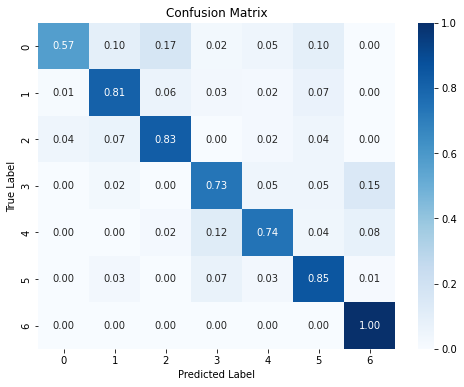

In [40]:
y_pred_probs = model.predict(valid_images)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = valid_labels

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬을 정규화
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 데이터에서 클래스 이름 가져오기
classes = ["0", "1", "2", "3", "4", "5", "6"] # Replace with your actual class names

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 2) 2차 CNN 모델 ( Conv2D 1x1 추가 )

In [65]:
model = load_model('cnn2.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

11/11 [==============================] - 0s 19ms/step - loss: 1.1525 - accuracy: 0.7381
{'Test Accuracy Rate: ': 73.81, 'Test Error Rate: ': 26.19}


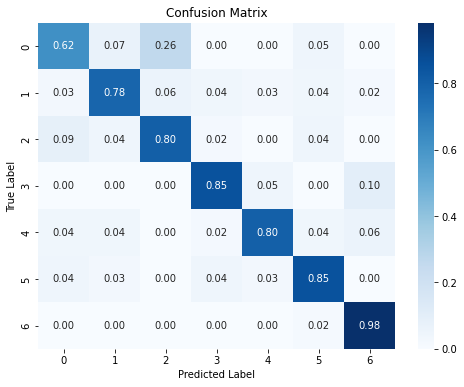

In [66]:
y_pred_probs = model.predict(valid_images)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = valid_labels

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬을 정규화
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 데이터에서 클래스 이름 가져오기
classes = ["0", "1", "2", "3", "4", "5", "6"] # Replace with your actual class names

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 3) MobileNetV2

In [42]:
model = load_model('mobile.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

11/11 [==============================] - 3s 70ms/step - loss: 0.3884 - accuracy: 0.8762
{'Test Accuracy Rate: ': 87.62, 'Test Error Rate: ': 12.38}


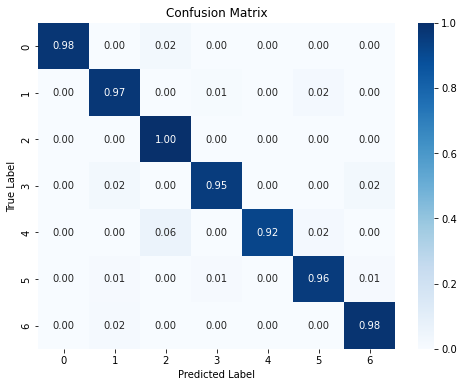

In [43]:
y_pred_probs = model.predict(valid_images)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = valid_labels

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬을 정규화
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 데이터에서 클래스 이름 가져오기
classes = ["0", "1", "2", "3", "4", "5", "6"] # Replace with your actual class names

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

##  4) VGG 16

In [45]:
model = load_model('vgg16.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

11/11 [==============================] - 9s 355ms/step - loss: 0.6018 - accuracy: 0.8381
{'Test Accuracy Rate: ': 83.81, 'Test Error Rate: ': 16.19}


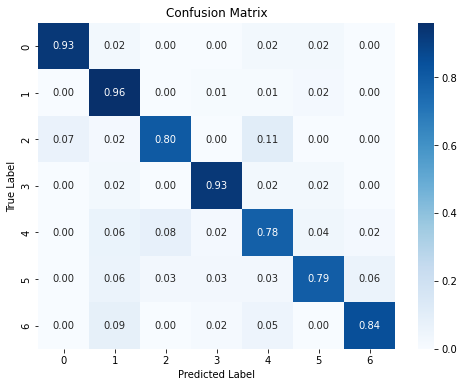

In [46]:
y_pred_probs = model.predict(valid_images)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = valid_labels

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬을 정규화
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 데이터에서 클래스 이름 가져오기
classes = ["0", "1", "2", "3", "4", "5", "6"] # Replace with your actual class names

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 5) VGG 19

In [48]:
model = load_model('vgg19.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

11/11 [==============================] - 2s 121ms/step - loss: 0.5873 - accuracy: 0.8286
{'Test Accuracy Rate: ': 82.86, 'Test Error Rate: ': 17.14}


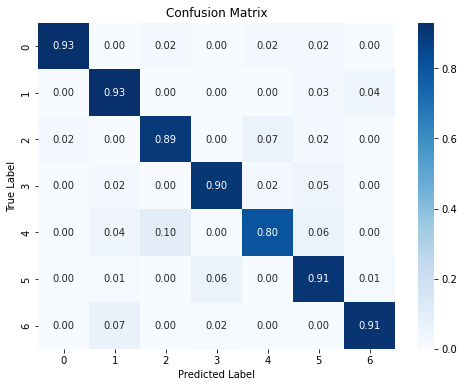

In [49]:
y_pred_probs = model.predict(valid_images)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = valid_labels

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬을 정규화
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 데이터에서 클래스 이름 가져오기
classes = ["0", "1", "2", "3", "4", "5", "6"] # Replace with your actual class names

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 6) InceptionV3

In [55]:
model = load_model('google.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

11/11 [==============================] - 4s 136ms/step - loss: 0.3425 - accuracy: 0.8952
{'Test Accuracy Rate: ': 89.52, 'Test Error Rate: ': 10.48}


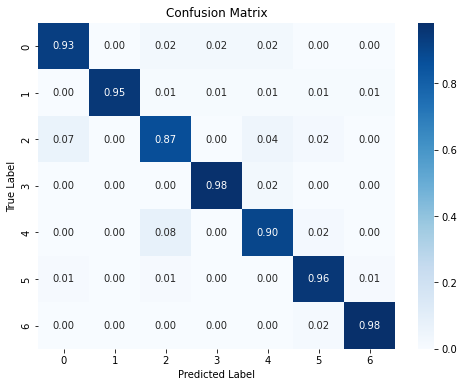

In [56]:
y_pred_probs = model.predict(valid_images)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = valid_labels

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬을 정규화
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 데이터에서 클래스 이름 가져오기
classes = ["0", "1", "2", "3", "4", "5", "6"] # Replace with your actual class names

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 7) DenseNet

In [52]:
model = load_model('dense.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

11/11 [==============================] - 5s 173ms/step - loss: 0.3455 - accuracy: 0.9190
{'Test Accuracy Rate: ': 91.9, 'Test Error Rate: ': 8.1}


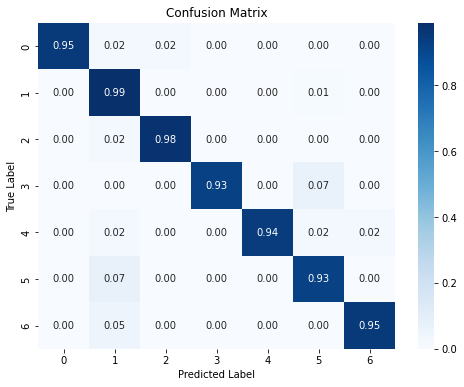

In [53]:
y_pred_probs = model.predict(valid_images)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true = valid_labels

conf_matrix = confusion_matrix(y_true, y_pred_labels)

# 혼동 행렬을 정규화
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 데이터에서 클래스 이름 가져오기
classes = ["0", "1", "2", "3", "4", "5", "6"] # Replace with your actual class names

# 히트맵 생성
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()